In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit
import time
import seaborn as sns
import random

import scipy as sp
from scipy.spatial.distance import mahalanobis

# these are user defined modules

### Read the extracted data

In [2]:
data = pd.read_csv('./data/author-career-short-snapshot.csv')

print(data.shape)
credibleAuthors = data[data['career_length'] >= 15]
print(credibleAuthors.shape)

#print(credibleAuthors.head(2))
print(credibleAuthors.columns)

(1708185, 52)
(126157, 52)
Index(['author', 'start_year', 'career_length', 'gender', 'npub_yr15',
       'ncit_yr15_pub_yr15', 'ncit_yr15_top_3_pub', 'npub_yr3',
       'ncit_yr15_pub_yr3', 'ncit_yr14_pub_yr3', 'ncit_yr13_pub_yr3',
       'ncit_yr12_pub_yr3', 'ncit_yr11_pub_yr3', 'ncit_yr10_pub_yr3',
       'ncit_yr9_pub_yr3', 'ncit_yr8_pub_yr3', 'ncit_yr7_pub_yr3',
       'ncit_yr6_pub_yr3', 'ncit_yr5_pub_yr3', 'ncit_yr4_pub_yr3',
       'ncit_yr3_pub_yr3', 'npub_yr2', 'ncit_yr15_pub_yr2',
       'ncit_yr14_pub_yr2', 'ncit_yr13_pub_yr2', 'ncit_yr12_pub_yr2',
       'ncit_yr11_pub_yr2', 'ncit_yr10_pub_yr2', 'ncit_yr9_pub_yr2',
       'ncit_yr8_pub_yr2', 'ncit_yr7_pub_yr2', 'ncit_yr6_pub_yr2',
       'ncit_yr5_pub_yr2', 'ncit_yr4_pub_yr2', 'ncit_yr3_pub_yr2',
       'ncit_yr2_pub_yr2', 'npub_yr1', 'ncit_yr15_pub_yr1',
       'ncit_yr14_pub_yr1', 'ncit_yr13_pub_yr1', 'ncit_yr12_pub_yr1',
       'ncit_yr11_pub_yr1', 'ncit_yr10_pub_yr1', 'ncit_yr9_pub_yr1',
       'ncit_yr8_pub_yr1', 'ncit

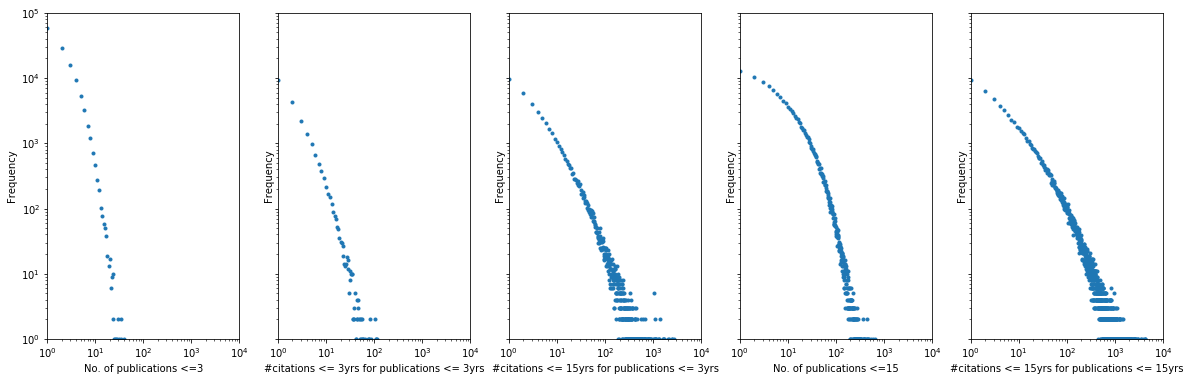

            npub_yr3  ncit_yr3_pub_yr3  ncit_yr15_pub_yr3      npub_yr15  \
count  126157.000000     126157.000000      126157.000000  126157.000000   
mean        2.316962          0.559390           6.701745      16.942318   
std         1.950497          2.338683          35.169849      23.263105   
min         1.000000          0.000000           0.000000       1.000000   
25%         1.000000          0.000000           0.000000       3.000000   
50%         2.000000          0.000000           0.000000       9.000000   
75%         3.000000          0.000000           3.000000      21.000000   
max        40.000000        117.000000        2775.000000     634.000000   

       ncit_yr15_pub_yr15  
count       126157.000000  
mean            31.099511  
std            102.568735  
min              0.000000  
25%              0.000000  
50%              3.000000  
75%             20.000000  
max           4297.000000  


In [3]:
fig, axes = plt.subplots(1,5,figsize=(20,6),sharey=True)
axes[0].plot(credibleAuthors['npub_yr3'].value_counts(),'.')
axes[0].set_xlabel('No. of publications <=3')
axes[0].set_xscale('log')
axes[0].set_xlim(1, 10000)
axes[0].set_ylabel('Frequency')
axes[0].set_yscale('log')
axes[0].set_ylim(1, 100000)


axes[1].plot(credibleAuthors['ncit_yr3_pub_yr3'].value_counts(),'.')
axes[1].set_xlabel('#citations <= 3yrs for publications <= 3yrs')
axes[1].set_xscale('log')
axes[1].set_xlim(1, 10000)
axes[1].set_ylabel('Frequency')
axes[1].set_yscale('log')
axes[1].set_ylim(1, 100000)


axes[2].plot(credibleAuthors['ncit_yr15_pub_yr3'].value_counts(),'.')
axes[2].set_xlabel('#citations <= 15yrs for publications <= 3yrs')
axes[2].set_xscale('log')
axes[2].set_xlim(1, 10000)
axes[2].set_ylabel('Frequency')
axes[2].set_yscale('log')
axes[2].set_ylim(1, 100000)


axes[3].plot(credibleAuthors['npub_yr15'].value_counts(),'.')
axes[3].set_xlabel('No. of publications <=15')
axes[3].set_xscale('log')
axes[3].set_xlim(1, 10000)
axes[3].set_ylabel('Frequency')
axes[3].set_yscale('log')
axes[3].set_ylim(1, 100000)


axes[4].plot(credibleAuthors['ncit_yr15_pub_yr15'].value_counts(),'.')
axes[4].set_xlabel('#citations <= 15yrs for publications <= 15yrs')
axes[4].set_xscale('log')
axes[4].set_xlim(1, 10000)
axes[4].set_ylabel('Frequency')
axes[4].set_yscale('log')
axes[4].set_ylim(1, 100000)


plt.show()

print(credibleAuthors[['npub_yr3','ncit_yr3_pub_yr3','ncit_yr15_pub_yr3','npub_yr15','ncit_yr15_pub_yr15']].describe())
# print(credibleAuthors['ncit_yr3_pub_yr3'].describe())
# print(credibleAuthors['ncit_yr15_pub_yr3'].describe())
# print(credibleAuthors['npub_yr15'].describe())
# print(credibleAuthors['ncit_yr15_pub_yr15'].describe())

### Remove authors who have not been citated at all

In [4]:
print('No. of authors - ',credibleAuthors.shape)
print('No. authors who have not been cited at all  - ',credibleAuthors[credibleAuthors['ncit_yr15_pub_yr15'] == 0].shape)
credibleAuthors = credibleAuthors[credibleAuthors['ncit_yr15_pub_yr15'] != 0]
print('No. of authors after removal - ',credibleAuthors.shape)

No. of authors -  (126157, 52)
No. authors who have not been cited at all  -  (45956, 52)
No. of authors after removal -  (80201, 52)


#### No. of publications <= 3 years has a power law effect. Since a lot of authors published very few papers and very few have published a lot, binning is done with non-linear ranges.
* Authors who have published more than 15 papers are in one bin (all the way upto 40)
* 10 to 14 in one bin
* 7 to 9, 4 to 6, 3, 2 ,1 are binned respectively

(1, 100000)

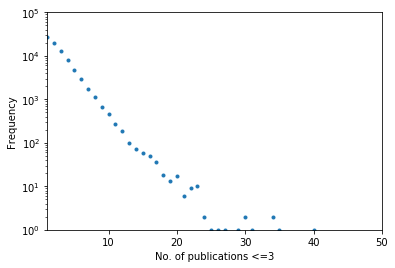

In [5]:
fig, ax =  plt.subplots(1,1)
ax.plot(credibleAuthors['npub_yr3'].value_counts(),'.')
ax.set_xlabel('No. of publications <=3')
#ax.set_xscale('log')
ax.set_xlim(1, 50)
ax.set_ylabel('Frequency')
ax.set_yscale('log')
ax.set_ylim(1, 100000)

In [6]:
year_bins = [1,2,3,4,7,10,16,100]
#bins - contains the year groups and labels contains all the group except the last one
credibleAuthors['npub_yr3_bin'] = pd.cut(credibleAuthors['npub_yr3'], bins=year_bins, labels=year_bins[:-1],\
                                       include_lowest=True, right=False)

credibleAuthors['npub_yr3_bin'].value_counts()

1     27251
2     19324
4     15865
3     12896
7      3553
10     1140
16      172
Name: npub_yr3_bin, dtype: int64

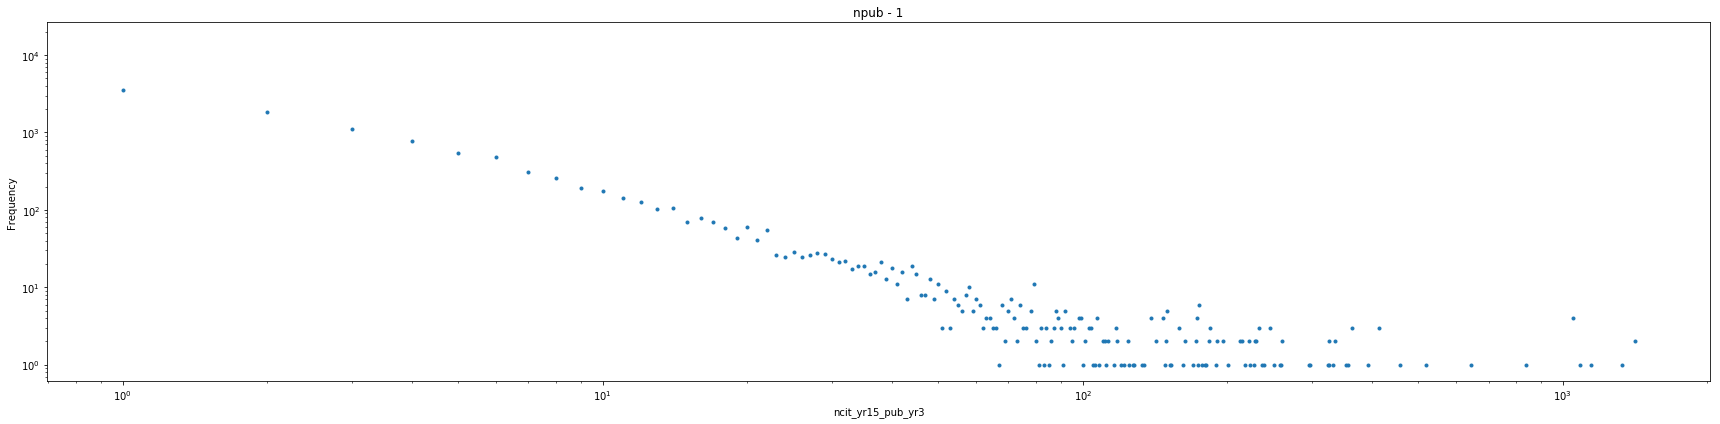

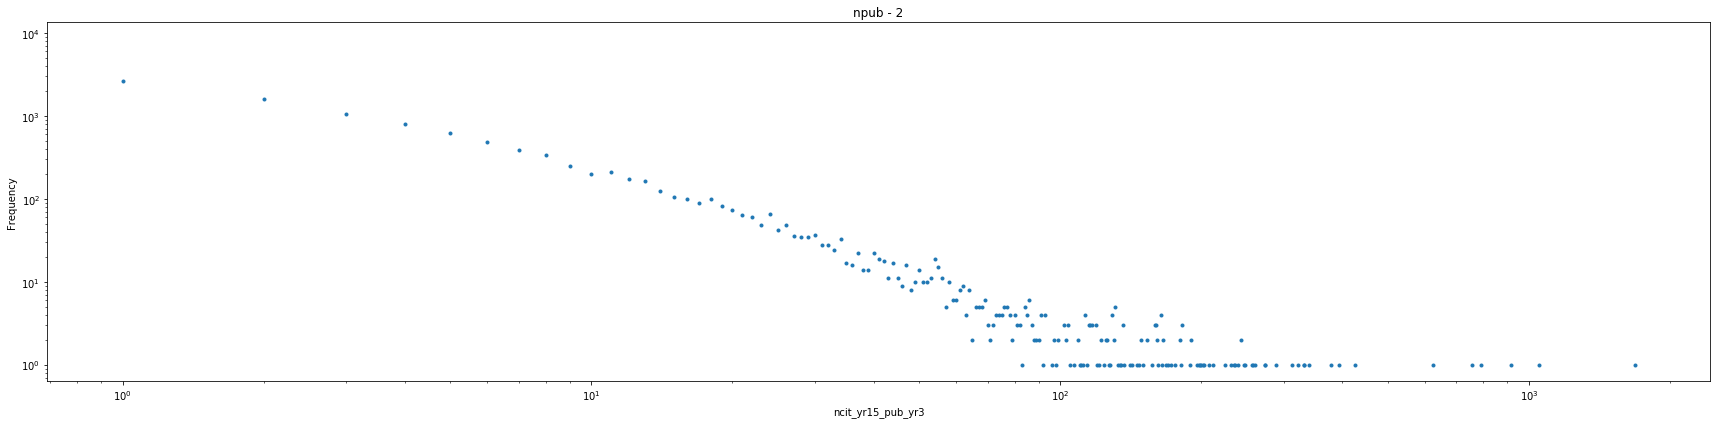

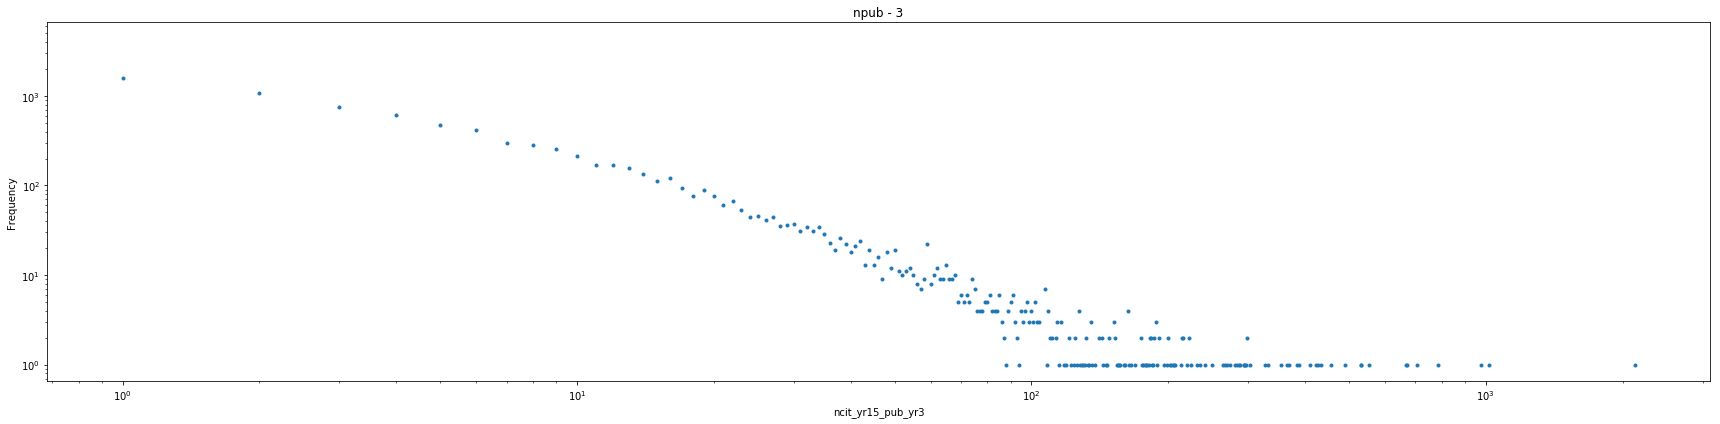

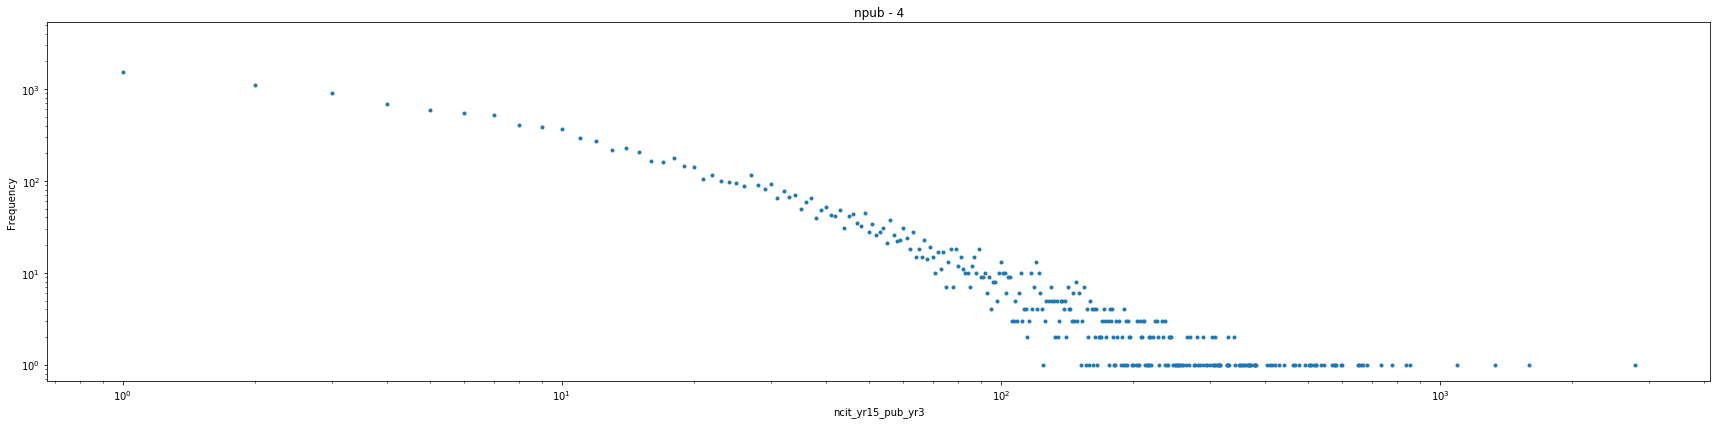

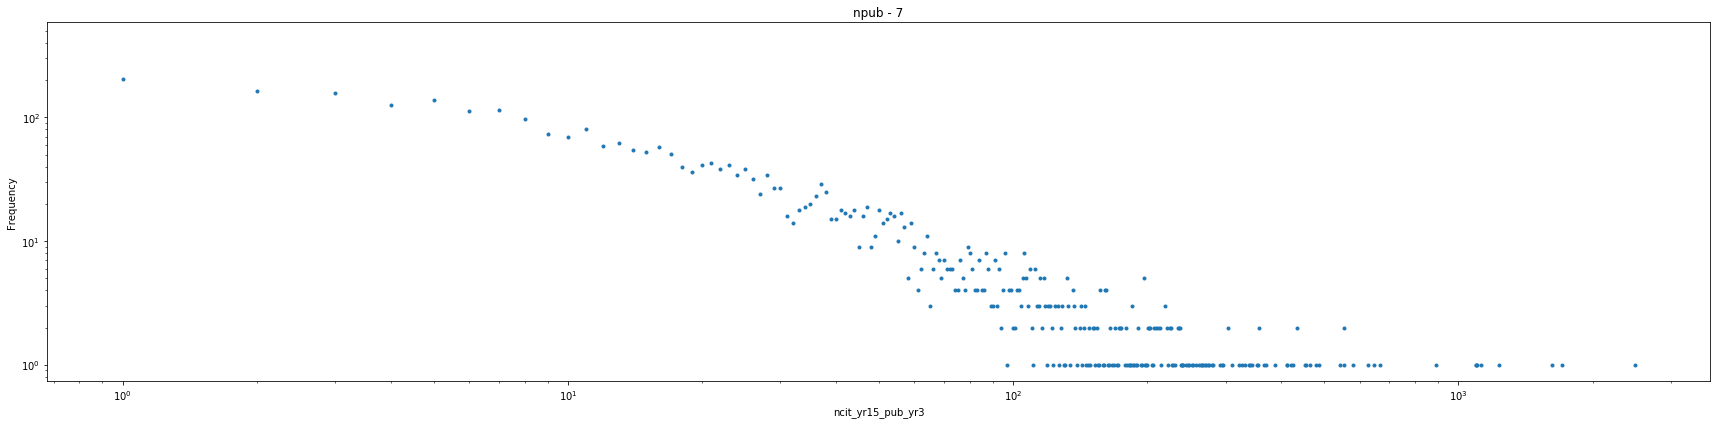

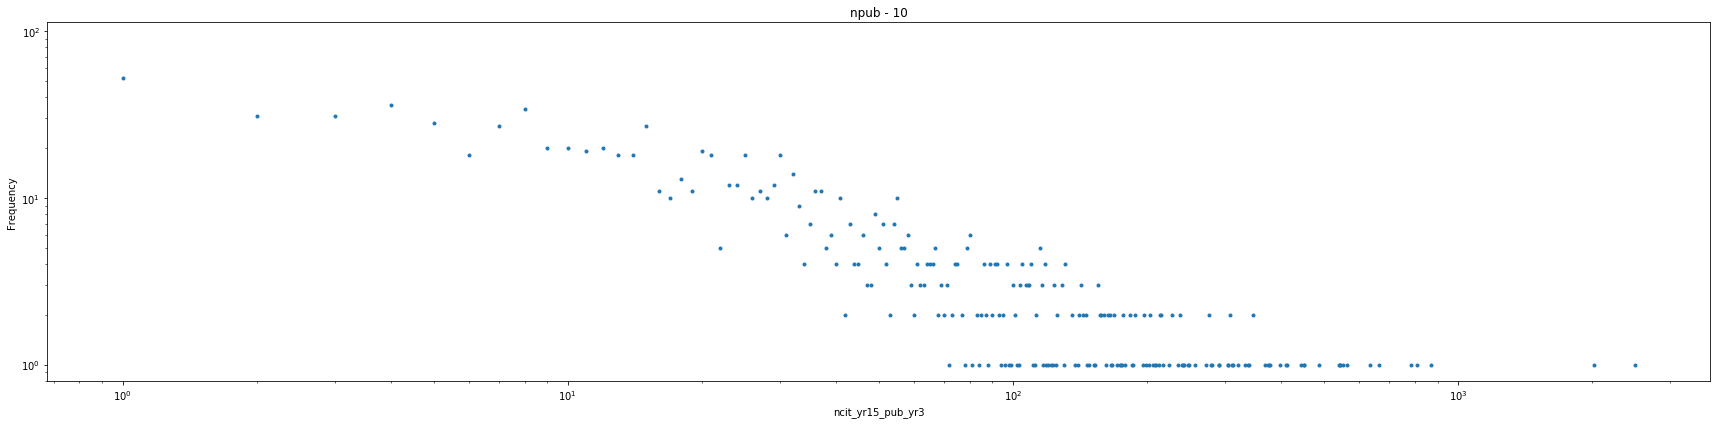

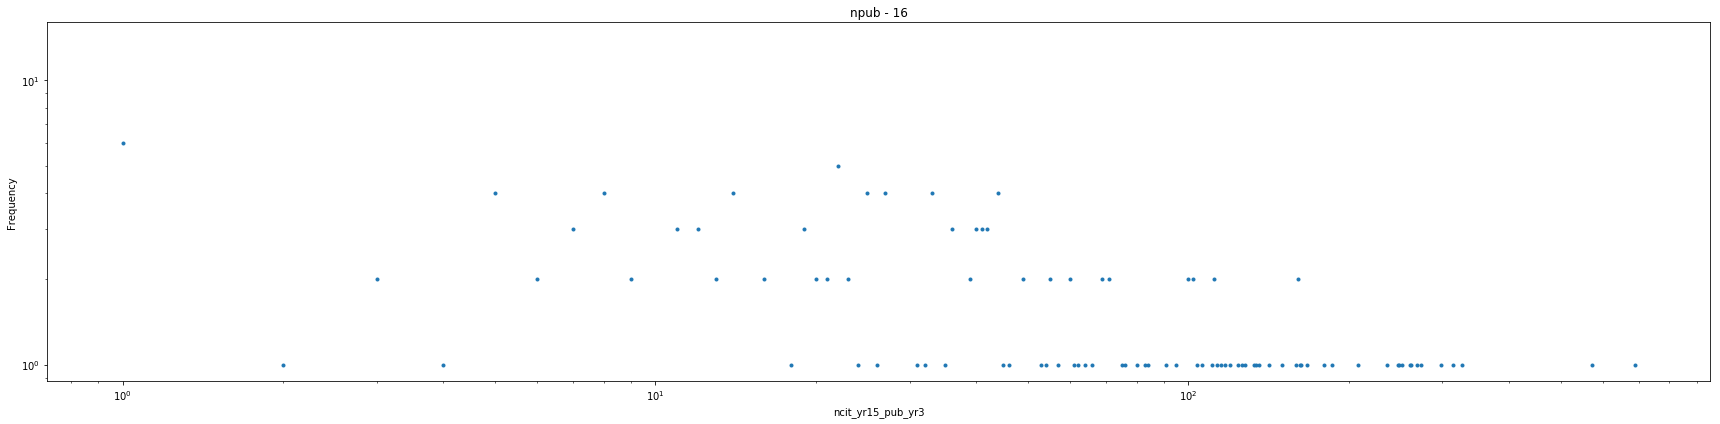

In [7]:

i = 0
#j = 0
bins = credibleAuthors['npub_yr3_bin'].unique().to_dense()
bins = np.sort(bins)

nrows = 1
ncols = 1
    
for b in bins:
    fig, axes = plt.subplots(nrows, ncols, figsize=(24, 6), sharey=True)
    tmpData = credibleAuthors[credibleAuthors['npub_yr3_bin'] == b]
    axes.set_title('npub - '+str(b))
    axes.plot(tmpData['ncit_yr15_pub_yr3'].value_counts(),'.')
    axes.set_xlabel('ncit_yr15_pub_yr3')
    axes.set_xscale('log')

    axes.set_ylabel('Frequency')
    axes.set_yscale('log')
#    axes.set_ylim(1, 100000)
    
    i = i+1
    plt.tight_layout()
    
    #print(tmpData['ncit_yr15_pub_yr3'].describe())

plt.show()

#print(credibleAuthors[['npub_yr3','ncit_yr3_pub_yr3','ncit_yr15_pub_yr3','npub_yr15','ncit_yr15_pub_yr15']].describe())

In [12]:
min_year = data['start_year'].min() 

# the final year was getting missed out from grouping. Inorder to avoid that the max year is extended by one group year
# pd.cut() function groups the years and allows the user to assign labels to each group. 
# It is designed in such a way that it was by default leaving the label for the last group. In order to fix this issue, 
# an extra bin is added to the last, so that, the second last (which is the actual last with respect to this context) is preserved

# this max_year is used only for grouping - so no worries :-)
max_year = data['start_year'].max() + 2*group_year 
yearGroups = range(min_year, max_year, group_year)

#bins - contains the year groups and labels contains all the group except the last one
data['year'] = pd.cut(data['year'], bins=yearGroups, labels=yearGroups[:-1],\
                                       include_lowest=True, right=False)
if 'start_year' in data.columns:
    data['start_year'] = pd.cut(data['start_year'],bins=yearGroups, labels=yearGroups[:-1],\
                                include_lowest=True, right=False)

if 'end_year' in data.columns:
    data['end_year'] = pd.cut(data['end_year'],bins=yearGroups, labels=yearGroups[:-1],\
                              include_lowest=True, right=False)

# within the group - all the multiple efforts need to be joined together
data[criterion] = data.groupby(['year', 'author'])[criterion].transform(np.sum)

NameError: name 'group_year' is not defined

In [ ]:
data['npub_yr3'].value_counts()

In [ ]:
data['ncit_yr3_pub_yr3'].value_counts()

In [ ]:
data['ncit_yr15_pub_yr3'].value_counts()

In [13]:
# credibleAuthors["ncit_yr15_pub_yr15_log"]=credibleAuthors['ncit_yr15_pub_yr15'].apply(lambda x: np.log(1 + x))
# credibleAuthors["ncit_yr15_pub_yr15_log"].value_counts().plot()

# from scipy.stats import norm
# sns.distplot(credibleAuthors['norm_ncit_yr15_pub_yr3'], fit=norm, kde=False)
# plt.show()
# plt.hist(np.log(1+credibleAuthors['ncit_yr15_pub_yr15']),bins=100)
# plt.xlim(-0.10,6)

# credibleAuthors[credibleAuthors['ncit_yr3_pub_yr3'] > 22]['ncit_yr3_pub_yr3'].value_counts().plot()
# credibleAuthors[credibleAuthors['ncit_yr3_pub_yr3'] > 22]['ncit_yr3_pub_yr3'].describe()

#### Segregate the authors into producers/Achievers - low/high bin and cross check broadly whether they are correct with the other sources in the web

In [14]:
credibleAuthors.sort_values(by='npub_yr3', ascending=False)[['author','start_year','npub_yr3','npub_yr15',
                                                             'ncit_yr3_pub_yr3',
                                                             'ncit_yr15_pub_yr3']].head(10)

,author,start_year,npub_yr3,npub_yr15,ncit_yr3_pub_yr3,ncit_yr15_pub_yr3
617969,irith pomeranz,1991,40,306,24.0,261.0
1285949,rohit goyal,1997,35,44,23.0,111.0
934751,mahmut t. kandemir,1997,34,457,24.0,248.0
1408279,sonia fahmy,1997,34,101,23.0,113.0
232764,charles safran,1997,31,61,0.0,0.0
1137696,omer f. rana,1999,30,214,9.0,45.0
1021438,michael backes 1,2002,30,153,30.0,326.0
57266,alexander maedche,2000,29,74,43.0,573.0
832347,klaus jansen,1992,27,111,0.0,27.0
48197,albrecht schmidt 1,1999,26,234,15.0,186.0


In [15]:
#anyone who published less than 5 papers in 3 yrs is a low producer.
#if their work got only 2 to 5 citations then they are low achievers too
#if their work got between 50 and 100 citations then are considered as high achiever
lowProducers = credibleAuthors[credibleAuthors['npub_yr3'] <= 5]
low2Achievers = lowProducers[(lowProducers['ncit_yr3_pub_yr3'] >=2) & (lowProducers['ncit_yr3_pub_yr3'] <=5)]
print(low2Achievers[['author','start_year','npub_yr3','npub_yr15','ncit_yr3_pub_yr3',
                                                             'ncit_yr15_pub_yr3']].head(10))

lowProductionhighAchievers = lowProducers[(lowProducers['ncit_yr3_pub_yr3'] >=50) & (lowProducers['ncit_yr3_pub_yr3'] <=100)]
print(lowProductionhighAchievers[['author','start_year','npub_yr3','npub_yr15','ncit_yr3_pub_yr3',
                                                             'ncit_yr15_pub_yr3']].head(10))

                  author  start_year  npub_yr3  npub_yr15  ncit_yr3_pub_yr3  \
298           a. a. khan        1994         2          5               5.0   
1884       a. bensoussan        1972         1          1               5.0   
4533          a. fantini        1997         1          1               2.0   
4768   a. frank ackerman        1989         3          3               5.0   
5230              a. gay        1993         1          1               2.0   
5367      a. gill waters        1984         2          4               4.0   
8614              a. lee        1983         1          2               5.0   
10750  a. nico habermann        1971         4         11               5.0   
12438       a. ravindran        1980         2          5               2.0   
12781   a. s. a. du toit        2001         2          9               2.0   

       ncit_yr15_pub_yr3  
298                 32.0  
1884                14.0  
4533                 2.0  
4768                30

In [16]:
#anyone who published atleast 12 papers in 3 yrs is a high producer.
#if their work got only 2 to 5 citations then they are low achievers
#if their work got between 50 and 100 citations then are considered as high achievers
highProducers = credibleAuthors[credibleAuthors['npub_yr3'] >= 12]
highProductionLowAchievers = highProducers[(highProducers['ncit_yr3_pub_yr3'] >=2) & (highProducers['ncit_yr3_pub_yr3'] <=5)]
print(highProductionLowAchievers[['author','start_year','npub_yr3','npub_yr15','ncit_yr3_pub_yr3',
                                                             'ncit_yr15_pub_yr3']].head(10))
high2Achievers = highProducers[(highProducers['ncit_yr3_pub_yr3'] >=50) & (highProducers['ncit_yr3_pub_yr3'] <=100)]
print(high2Achievers.sort_values(by='ncit_yr3_pub_yr3', ascending=False)[['author','start_year','npub_yr3','npub_yr15','ncit_yr3_pub_yr3',
                                                                          'ncit_yr15_pub_yr3']].head(10))

                         author  start_year  npub_yr3  npub_yr15  \
10520         a. n. rajagopalan        1997        12         50   
16478            aapo hyvärinen        1996        12         90   
18084               abbes amira        2001        20        111   
47244      alberto garcía ortiz        2002        17         50   
61229  alexandros eleftheriadis        1993        13         61   
77259     amit k. roy-chowdhury        2001        15        144   
84484             anders heyden        1995        12         93   
86574     andrea e. f. clementi        1994        16         56   
91026     andreas schmietendorf        2000        17         41   
93193           andrew b. kahng        1990        16        187   

       ncit_yr3_pub_yr3  ncit_yr15_pub_yr3  
10520               4.0               37.0  
16478               3.0              337.0  
18084               2.0                3.0  
47244               5.0                5.0  
61229               3.0   

In [17]:
#credibleAuthors[credibleAuthors['norm_ncit_yr15_pub_yr3']==0]
# credibleAuthors['norm_ncit_yr15_pub_yr3'].dtype
# credibleAuthors['norm_ncit_yr15_pub_yr3'].hist(bins=10000)
# 1/credibleAuthors['ncit_yr15_pub_yr3'].max()

Actual range values 4297.0 1.0


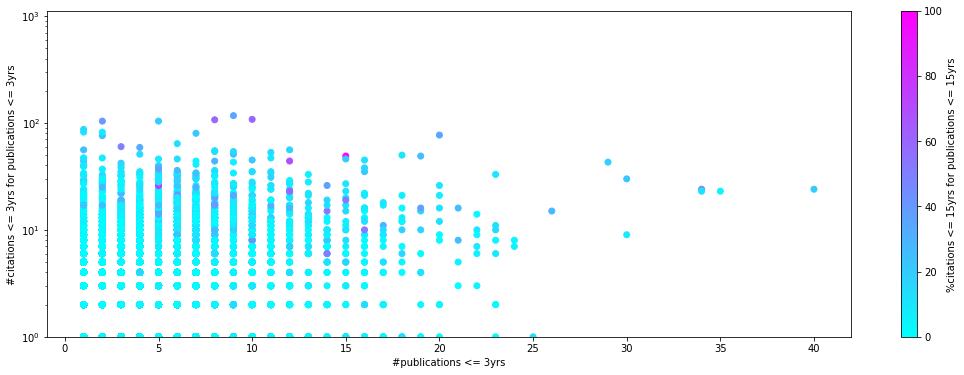

In [18]:
# Normalize(0 to 100) the citation obtained within 15 years for publication within 15 yrs
credibleAuthors['norm_ncit_yr15_pub_yr15'] = 100 * ((credibleAuthors['ncit_yr15_pub_yr15'] - credibleAuthors['ncit_yr15_pub_yr15'].min()) /
                                            (credibleAuthors['ncit_yr15_pub_yr15'].max() - credibleAuthors['ncit_yr15_pub_yr15'].min()))

print('Actual range values',credibleAuthors['ncit_yr15_pub_yr15'].max(), credibleAuthors['ncit_yr15_pub_yr15'].min())


fig, axes = plt.subplots(figsize=(18,6))

handle = axes.scatter(credibleAuthors['npub_yr3'], credibleAuthors['ncit_yr3_pub_yr3'], 
                       c=credibleAuthors['norm_ncit_yr15_pub_yr15'], cmap='cool')
axes.set_xlabel('#publications <= 3yrs')
axes.set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes.set_yscale('log')
axes.set_ylim(ymin=1)
cbar = fig.colorbar(handle)
cbar.set_label('%citations <= 15yrs for publications <= 15yrs')

plt.show()
#fig.savefig('fig/cit3_15yr-for-pub3_15yr.png')

Log values 8.365905077202456 0.6931471805599453


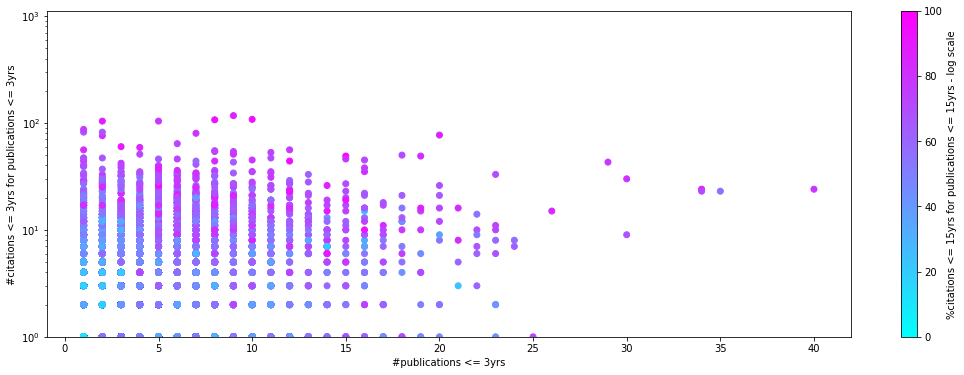

In [19]:
credibleAuthors["ncit_yr15_pub_yr15_log"]=credibleAuthors['ncit_yr15_pub_yr15'].apply(lambda x: np.log(1 + x))
temp_max=credibleAuthors['ncit_yr15_pub_yr15_log'].max()
temp_min=credibleAuthors['ncit_yr15_pub_yr15_log'].min()
print('Log values',temp_max, temp_min)
credibleAuthors['norm_ncit_yr15_pub_yr15_log'] = credibleAuthors.ncit_yr15_pub_yr15_log.apply(lambda x: 100 * (float(x - temp_min)
                                                                                                               /float(temp_max - temp_min)))

fig, axes = plt.subplots(figsize=(18,6))

handle = axes.scatter(credibleAuthors['npub_yr3'], credibleAuthors['ncit_yr3_pub_yr3'], 
                   c=credibleAuthors['norm_ncit_yr15_pub_yr15_log'], cmap='cool')
axes.set_xlabel('#publications <= 3yrs')
axes.set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes.set_yscale('log')
axes.set_ylim(ymin=1)
cbar = fig.colorbar(handle)
cbar.set_label('%citations <= 15yrs for publications <= 15yrs - log scale')

plt.show()

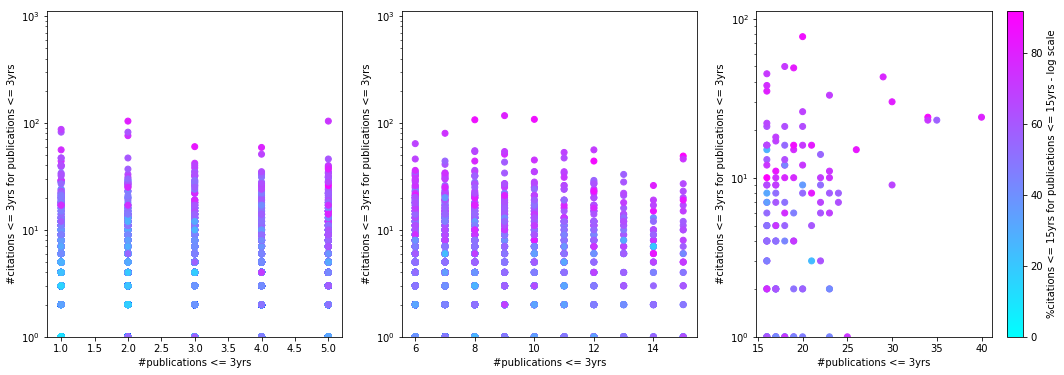

In [20]:
lowProducers = credibleAuthors[credibleAuthors['npub_yr3'] <= 5]
normalProducers = credibleAuthors[credibleAuthors['npub_yr3'] > 5]
normalProducers =  normalProducers[normalProducers['npub_yr3'] <= 15]
extraOrdinaryProducers = credibleAuthors[credibleAuthors['npub_yr3'] > 15]

fig, axes = plt.subplots(1,3,figsize=(18,6))
handle = axes[0].scatter(lowProducers['npub_yr3'], lowProducers['ncit_yr3_pub_yr3'], 
                   c=lowProducers['norm_ncit_yr15_pub_yr15_log'], cmap='cool')
axes[0].set_xlabel('#publications <= 3yrs')
axes[0].set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes[0].set_yscale('log')
axes[0].set_ylim(ymin=1)

handle = axes[1].scatter(normalProducers['npub_yr3'], normalProducers['ncit_yr3_pub_yr3'], 
                   c=normalProducers['norm_ncit_yr15_pub_yr15_log'], cmap='cool')
axes[1].set_xlabel('#publications <= 3yrs')
axes[1].set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes[1].set_yscale('log')
axes[1].set_ylim(ymin=1)

handle = axes[2].scatter(extraOrdinaryProducers['npub_yr3'], extraOrdinaryProducers['ncit_yr3_pub_yr3'], 
                   c=extraOrdinaryProducers['norm_ncit_yr15_pub_yr15_log'], cmap='cool')
axes[2].set_xlabel('#publications <= 3yrs')
axes[2].set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes[2].set_yscale('log')
axes[2].set_ylim(ymin=1)


cbar = fig.colorbar(handle)
cbar.set_label('%citations <= 15yrs for publications <= 15yrs - log scale')

plt.show()

In [21]:
print(credibleAuthors['ncit_yr3_pub_yr3'].describe())
print(credibleAuthors['ncit_yr3_pub_yr3'].value_counts().cumsum().head(10))

count    80201.000000
mean         0.879927
std          2.884695
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        117.000000
Name: ncit_yr3_pub_yr3, dtype: float64
0.0    58860
1.0    68275
2.0    72515
3.0    74697
4.0    76086
5.0    77063
6.0    77730
7.0    78206
8.0    78586
9.0    78877
Name: ncit_yr3_pub_yr3, dtype: int64


In [22]:
controlGroup =  credibleAuthors[credibleAuthors['ncit_yr3_pub_yr3'] < 10]
treatmentGroup =  credibleAuthors[credibleAuthors['ncit_yr3_pub_yr3'] >= 10]
filteredControlGroup = controlGroup.head(treatmentGroup.shape[0]*10)

In [23]:
print(controlGroup.shape)
print(treatmentGroup.shape)
print(filteredControlGroup.shape)

(78877, 56)
(1324, 56)
(13240, 56)


In [24]:
print(treatmentGroup.columns)
print(controlGroup.columns)

Index(['author', 'start_year', 'career_length', 'gender', 'npub_yr15',
       'ncit_yr15_pub_yr15', 'ncit_yr15_top_3_pub', 'npub_yr3',
       'ncit_yr15_pub_yr3', 'ncit_yr14_pub_yr3', 'ncit_yr13_pub_yr3',
       'ncit_yr12_pub_yr3', 'ncit_yr11_pub_yr3', 'ncit_yr10_pub_yr3',
       'ncit_yr9_pub_yr3', 'ncit_yr8_pub_yr3', 'ncit_yr7_pub_yr3',
       'ncit_yr6_pub_yr3', 'ncit_yr5_pub_yr3', 'ncit_yr4_pub_yr3',
       'ncit_yr3_pub_yr3', 'npub_yr2', 'ncit_yr15_pub_yr2',
       'ncit_yr14_pub_yr2', 'ncit_yr13_pub_yr2', 'ncit_yr12_pub_yr2',
       'ncit_yr11_pub_yr2', 'ncit_yr10_pub_yr2', 'ncit_yr9_pub_yr2',
       'ncit_yr8_pub_yr2', 'ncit_yr7_pub_yr2', 'ncit_yr6_pub_yr2',
       'ncit_yr5_pub_yr2', 'ncit_yr4_pub_yr2', 'ncit_yr3_pub_yr2',
       'ncit_yr2_pub_yr2', 'npub_yr1', 'ncit_yr15_pub_yr1',
       'ncit_yr14_pub_yr1', 'ncit_yr13_pub_yr1', 'ncit_yr12_pub_yr1',
       'ncit_yr11_pub_yr1', 'ncit_yr10_pub_yr1', 'ncit_yr9_pub_yr1',
       'ncit_yr8_pub_yr1', 'ncit_yr7_pub_yr1', 'ncit_yr6_pu

In [25]:
#controlGroup['npub_yr3']

In [26]:
tmp = controlGroup.shape[0]
tmp

78877

In [27]:
covariance = credibleAuthors[['npub_yr3']].cov()
invCovariance = sp.linalg.inv(covariance)
print(invCovariance)

[[0.2068987]]


In [28]:
tmpGroup = (controlGroup['npub_yr3'].subtract(2))
print(tmpGroup.shape)
tmpGroup = tmpGroup.reshape(tmp,1)
print(tmpGroup.shape)

(78877,)
(78877, 1)


/home/danielkostic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
tmpGroup1 = np.dot(tmpGroup, invCovariance) 
print(tmpGroup1.shape)

(78877, 1)


In [30]:
tmpGroup1.shape

(78877, 1)

In [31]:
tmpGroup.shape

(78877, 1)

In [32]:
tmpGroup.T.shape

(1, 78877)

In [33]:
np.multiply(tmpGroup1, tmpGroup)

array([[0.2068987],
       [0.       ],
       [0.2068987],
       ...,
       [0.       ],
       [0.2068987],
       [0.       ]])

In [34]:
tmp

78877

In [35]:
def anotherFunc(var, counter):
    print(var)
    counter.append(1)
    return 0

counter = []
treatmentGroup.apply(lambda x:(anotherFunc(x['npub_yr3'], counter)), axis=1)
print(sum(counter))
print(treatmentGroup.shape)

5
5
7
1
10
3
4
8
1
3
2
7
11
15
10
12
6
2
2
4
7
1
3
2
15
6
26
2
4
5
23
1
5
5
5
7
1
29
3
18
6
7
5
6
8
13
4
3
6
9
4
8
7
4
8
15
1
5
7
7
6
10
4
16
2
7
8
7
10
6
4
8
6
1
10
10
12
6
10
10
7
5
3
6
4
4
10
12
4
5
10
10
1
6
4
13
3
7
9
10
3
3
4
6
4
14
10
3
6
3
5
3
7
8
13
3
6
6
4
6
2
6
4
2
6
4
3
3
6
1
22
5
19
4
4
5
3
10
1
2
5
3
3
7
1
1
6
3
6
6
4
7
1
7
1
2
8
1
11
2
4
5
12
1
9
3
5
3
4
12
15
6
2
1
10
1
9
4
8
6
1
3
3
9
5
7
8
1
6
2
7
2
5
9
6
10
8
5
6
8
6
6
13
8
8
5
6
1
5
3
9
5
9
12
6
8
7
3
10
7
13
8
3
22
4
2
2
6
4
13
3
5
23
9
6
5
3
7
4
3
4
8
5
6
1
3
3
2
3
7
7
1
11
4
9
2
5
5
1
1
11
4
1
3
7
3
6
8
2
14
9
2
4
4
8
3
7
2
4
6
8
11
2
6
6
15
12
6
8
12
9
3
1
3
9
12
7
8
1
3
3
10
1
3
6
1
1
15
8
8
1
2
9
3
6
1
8
16
1
5
9
13
2
5
9
18
8
6
3
4
3
2
8
2
1
4
4
4
3
4
3
17
4
4
8
2
5
4
5
1
3
10
3
7
2
5
1
12
10
17
12
2
4
8
4
10
11
1
8
1
3
5
7
11
1
2
6
2
7
9
5
16
1
12
16
3
9
5
15
7
5
6
7
9
5
1
7
7
7
8
7
6
5
8
20
2
14
5
11
3
8
6
3
4
3
10
1
7
1
6
2
5
7
8
5
2
6
7
5
8
6
3
11
2
2
1
5
3
6
4
12
11
1
10
4
4
9
3
3
14
1
6
3
7
4
3
8
13
5
6

In [36]:
def mahanabFunc(treatmentVar, controlGroup, invCovariance,counterVar):
    print(type(controlGroup))

    print('Is',type(treatmentVar))
    counterVar.append(1)
    print(sum(counterVar))
    tmpShape = controlGroup.shape
    tmpRows = controlGroup.shape[0]
    #print('1 - is fine')
    if (len(tmpShape) > 1):
        tmpColumns = controlGroup.shape[1]
    else:
        tmpColumns = 1
    if (treatmentVar is None):
        return np.NaN
    #print('2 - is fine')
    tmpGroup = (controlGroup.subtract(treatmentVar))
    print('X',type(tmpGroup))
    #print(tmpGroup.shape)
    #tmpGroup = pd.Series.reshape(tmpGroup, tmpRows, tmpColumns)
    print('After Reshape',type(tmpGroup))
    #print(tmpGroup.shape)
    #print('3 - is fine')
    tmpGroup1 = pd.Series.dot(tmpGroup.T, invCovariance) 
    print('After dot',type(tmpGroup1))

    if (tmpColumns == 1):
        tmpResult = pd.Series.multiply(tmpGroup1, tmpGroup)
    else:
        tmpResult = pd.Series.dot(tmpGroup1, tmpGroup.T)
    print('4 - is fine')
    #print('Result:', np.sqrt(tmpResult))  
    print(type(tmpResult))
    tmpResult =  pd.Series.sqrt(tmpResult)
    print(type(tmpResult))
    print(tmpResult.shape)
    return tmpResult
    #print(type(tmpGroup))
#     if(sum(counterVar) > 100 ):
#         return np.array([0,1,23,2343,5,656])
#     else:
#         return np.array([0,1])
    #return np.array([0,1,23,2343,5,656])

In [37]:
output_variable = 'ncit_yr15_pub_yr15'

controlGroup.loc[0][output_variable]

9.0

In [38]:
controlGroup['npub_yr3'].shape

(78877,)

In [39]:
# for index, row in treatmentGroup.iterrows():
#     print (np.sqrt(np.dot(np.dot((controlGroup['npub_yr3']-row[['npub_yr3']]),invCovariance),(controlGroup['npub_yr3']-row[['npub_yr3']]).T)))
#     break

#treatmentGroup.apply(lambda x:(x[['npub_yr3']] - controlGroup[['npub_yr3']]), axis=1)
# treatmentGroup.apply(lambda x:( np.sqrt( np.dot(controlGroup['npub_yr3'].subtract(x['npub_yr3']), 
#                                         (controlGroup['npub_yr3'].subtract(x['npub_yr3'])).T))), axis=1)

# treatmentGroup.apply(lambda x:(np.sqrt(
#             np.multiply(np.dot(((controlGroup['npub_yr3'].subtract(x['npub_yr3'])).reshape(tmp,1)), invCovariance),
#                        ((controlGroup['npub_yr3'].subtract(x['npub_yr3'])).reshape(tmp,1))))), axis=1)

# treatmentGroup.apply(lambda x:(np.sqrt(
#             np.multiply(np.dot(((controlGroup['npub_yr3'].subtract(x['npub_yr3'])).reshape(tmp,1)), invCovariance),
#                        ((controlGroup['npub_yr3'].subtract(x['npub_yr3'])).reshape(tmp,1))))), axis=1)
counter = []
# treatmentGroup.apply(lambda x:(mahanabFunc( x['npub_yr3'], controlGroup['npub_yr3'], invCovariance, counter)), axis=1)

newData = pd.DataFrame(columns=['control_index','control_output', 'treatment_index','treatment_output'])

output_variable = 'ncit_yr15_pub_yr15'

for index, row in treatmentGroup.iterrows():
    temp = mahanabFunc( row['npub_yr3'], controlGroup['npub_yr3'], invCovariance, counter)
    newData.append({'control_index':temp.idxmin(), 'control_output':controlGroup[temp.idxmin()][output_variable], 
                    'treatment_index':index, 'treatment_output':row[output_variable]}, ignore_index=True)
    #print(index, temp.idxmin())


<class 'pandas.core.series.Series'>
Is <class 'int'>
1
X <class 'pandas.core.series.Series'>
After Reshape <class 'pandas.core.series.Series'>


Exception: Dot product shape mismatch, (78877,) vs (1, 1)

In [ ]:
sum(counter)

In [ ]:
treatmentGroup.shape

In [ ]:
controlGroup.shape

In [ ]:
#tempCov = credibleAuthors[['npub_yr3', 'ncit_yr3_pub_yr3']].cov()
#invCov = sp.linalg.inv(tempCov)

vecMahalanobis = np.vectorize(mahalanobis)

covariance = credibleAuthors[['npub_yr3']].cov()
invCovariance = sp.linalg.inv(covariance)
i = 0
for index, row in treatmentGroup.iterrows():
    #print(row['npub_yr3'])
    temp = filteredControlGroup.apply(lambda x: (mahalanobis(row[['npub_yr3']], x['npub_yr3'], invCovariance)), axis=1)
    #temp = vecMahalanobis(row['npub_yr3'], controlGroup[['npub_yr3']], invCovariance)
    
    print(index, temp.idxmin())
    i = i + 1
    if i >= 10:
        break
    #print(temp)
    #break
    
#Calculate Mahalanobis distance
#

# temp1 = credibleAuthors.apply(lambda row: (mahalanobis(credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']], 
#                                                        row[['npub_yr3','ncit_yr3_pub_yr3']], invCov)), axis=1)

In [ ]:
temp.idxmin()

In [ ]:
treatmentGroup.index

In [ ]:
fig, axes = plt.subplots(figsize=(18,6))
axes.scatter(lowProducers["ncit_yr3_pub_yr3"], lowProducers["norm_ncit_yr15_pub_yr15_log"],  c="r", s=6)
axes.scatter(normalProducers["ncit_yr3_pub_yr3"], normalProducers["norm_ncit_yr15_pub_yr15_log"],  c="g", s=6)
axes.scatter(extraOrdinaryProducers["ncit_yr3_pub_yr3"], extraOrdinaryProducers["norm_ncit_yr15_pub_yr15_log"],  c="b", s=6)

plt.show()

In [ ]:
#plt.xcorr(lowProducers['ncit_yr3_pub_yr3'], lowProducers['norm_ncit_yr15_pub_yr15_log'])
lp_corr = lowProducers[['ncit_yr3_pub_yr3','norm_ncit_yr15_pub_yr15_log' ]].corr()
np_corr = normalProducers[['ncit_yr3_pub_yr3','norm_ncit_yr15_pub_yr15_log' ]].corr()
ep_corr = extraOrdinaryProducers[['ncit_yr3_pub_yr3','norm_ncit_yr15_pub_yr15_log' ]].corr()
print(lp_corr)
print(np_corr)
print(ep_corr)

#fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(18,6))
g = sns.jointplot("ncit_yr3_pub_yr3", "norm_ncit_yr15_pub_yr15_log", data=lowProducers, kind="reg")
g = sns.jointplot("ncit_yr3_pub_yr3", "norm_ncit_yr15_pub_yr15_log", data=normalProducers, kind="reg")
g = sns.jointplot("ncit_yr3_pub_yr3", "norm_ncit_yr15_pub_yr15_log", data=extraOrdinaryProducers, kind="reg")

#g.jointplot("ncit_yr3_pub_yr3", "norm_ncit_yr15_pub_yr15_log", data=normalProducers, kind="reg")

In [ ]:
print(credibleAuthors[credibleAuthors['ncit_yr15_pub_yr15'] == 0].shape)
print(credibleAuthors[credibleAuthors['norm_ncit_yr15_pub_yr15'] == 0].shape)
print(credibleAuthors[credibleAuthors['ncit_yr15_pub_yr15_log'] <= 0].shape)
print(credibleAuthors[credibleAuthors['norm_ncit_yr15_pub_yr15_log'] <= 0].shape)

In [ ]:
credibleAuthors['ncit_yr15_pub_yr15'].shape

In [ ]:
credibleAuthors['ncit_yr15_pub_yr15_log'].hist()

In [ ]:
credibleAuthors['norm_ncit_yr15_pub_yr15'].hist()


In [ ]:
credibleAuthors['norm_ncit_yr15_pub_yr15_log'].hist()

In [ ]:
# Normalize(0 to 100) the citation obtained within 15 years for publication within 3 yrs
#credibleAuthors['norm_ncit_yr15_pub_yr3'] = 100 * ( (credibleAuthors['ncit_yr15_pub_yr3'] - credibleAuthors['ncit_yr15_pub_yr3'].min()) /
#                                            (credibleAuthors['ncit_yr15_pub_yr3'].max() - credibleAuthors['ncit_yr15_pub_yr3'].min()))
temp_max=credibleAuthors['ncit_yr15_pub_yr3'].max()
temp_min=credibleAuthors['ncit_yr15_pub_yr3'].min()
credibleAuthors['norm_ncit_yr15_pub_yr3'] = credibleAuthors.ncit_yr15_pub_yr3.apply(lambda x: 100 * ( float(x - temp_min)/float(temp_max - temp_min) ))

fig, axes = plt.subplots(figsize=(18,6))           

handle = axes.scatter(credibleAuthors['npub_yr3'], credibleAuthors['ncit_yr3_pub_yr3'], 
                   c=credibleAuthors['norm_ncit_yr15_pub_yr3'], cmap='cool')
axes.set_xlabel('#publications <= 3yrs')
axes.set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes.set_yscale('log')
axes.set_ylim(ymin=1)
cbar = fig.colorbar(handle)
cbar.set_label('%citations <= 15yrs for publications <= 3yrs')

plt.show()
#fig.savefig('fig/cit3_15yr-for-pub3yr.png')

In [ ]:
# Normalize(0 to 100) the citation obtained within 15 years for publication within 3 yrs
#credibleAuthors['norm_ncit_yr15_pub_yr3'] = 100 * ((credibleAuthors['ncit_yr15_pub_yr3'] - credibleAuthors['ncit_yr15_pub_yr3'].min()) /
#                                            (credibleAuthors['ncit_yr15_pub_yr3'].max() - credibleAuthors['ncit_yr15_pub_yr3'].min()))

temp_max=credibleAuthors['ncit_yr15_pub_yr15_log'].max()
temp_min=credibleAuthors['ncit_yr15_pub_yr15_log'].min()
credibleAuthors['norm_ncit_yr15_pub_yr15_log'] = credibleAuthors.ncit_yr15_pub_yr15_log.apply(lambda x: 100 * ( float(x - temp_min)
                                                                                                               /float(temp_max - temp_min) ))
print(temp_max)
print(temp_min)
#credibleAuthors['norm_ncit_yr15_pub_yr15_log']
fig, axes = plt.subplots(figsize=(18,6))

handle = axes.scatter(credibleAuthors['npub_yr3'], credibleAuthors['ncit_yr3_pub_yr3'], 
                   c=credibleAuthors['norm_ncit_yr15_pub_yr15_log'], cmap='cool')
axes.set_xlabel('#publications <= 3yrs')
axes.set_ylabel('#citations <= 3yrs for publications <= 3yrs')
axes.set_yscale('log')
axes.set_ylim(ymin=1)
cbar = fig.colorbar(handle)
cbar.set_label('%citations <= 15yrs for publications <= 3yrs')

plt.show()
# #fig.savefig('fig/cit3_15yr-for-pub3yr.png')

In [ ]:
#fig, axes = plt.subplots(figsize=(18,6))

#handle = axes.scatter(credibleAuthors['npub_yr3'], credibleAuthors['norm_ncit_yr15_pub_yr3'])
#credibleAuthors[['npub_yr3',"norm_ncit_yr15_pub_yr3"]].corr()
#sns.regplot(x="npub_yr3", y="norm_ncit_yr15_pub_yr3", data=credibleAuthors,);
sns.jointplot(x="npub_yr3", y="norm_ncit_yr15_pub_yr3", data=credibleAuthors, kind="reg");

In [ ]:
sns.jointplot(x="ncit_yr3_pub_yr3", y="ncit_yr15_pub_yr15_log", data=credibleAuthors, kind="reg");

In [ ]:
np.log10(10)# 2.35

In [ ]:
np.log(2.34) 

In [ ]:
sns.jointplot(x="ncit_yr3_pub_yr3", y="norm_ncit_yr15_pub_yr3", data=credibleAuthors, kind="reg",xlim=(-0.1,60));

In [ ]:
credibleAuthors[credibleAuthors.ncit_yr3_pub_yr3==0]#104816 is 0

In [ ]:
sns.jointplot(x="npub_yr3", y="ncit_yr3_pub_yr3", data=credibleAuthors, kind="reg");

In [ ]:
# https://franciscomorales.org/2017/03/09/how-to-python-calculate-mahalanobis-distance/

import pandas as pd
from scipy.spatial.distance import mahalanobis
 
datadict = {
'country': ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Ecuador', 'Colombia', 'Paraguay', 'Peru', 'Venezuela'],
'd1': [0.34, -0.19, 0.37, 1.17, -0.31, -0.3, -0.48, -0.15, -0.61],
'd2': [-0.57, -0.69, -0.28, 0.68, -2.19, -0.83, -0.53, -1, -1.39],
'd3': [-0.02, -0.55, 0.07, 1.2, -0.14, -0.85, -0.9, -0.47, -1.02],
'd4': [-0.69, -0.18, 0.05, 1.43, -0.02, -0.7, -0.72, 0.23, -1.08],
'd5': [-0.83, -0.69, -0.39, 1.31, -0.7, -0.75, -1.04, -0.52, -1.22],
'd6': [-0.45, -0.77, 0.05, 1.37, -0.1, -0.67, -1.4, -0.35, -0.89]}
 
pairsdict = {
'country1': ['Argentina', 'Chile', 'Ecuador', 'Peru'],
'country2': ['Bolivia', 'Venezuela', 'Colombia', 'Peru']}
 
#DataFrame that contains the data for each country
df = pd.DataFrame(datadict)
 
#DataFrame that contains the pairs for which we calculate the Mahalanobis distance
pairs = pd.DataFrame(pairsdict)
 
#Add data to the country pairs
pairs = pairs.merge(df, how='left', left_on=['country1'], right_on=['country'])
pairs = pairs.merge(df, how='left', left_on=['country2'], right_on=['country'])
 
#Convert data columns to list in a single cell
pairs['vector1'] = pairs[['d1_x','d2_x','d3_x','d4_x','d5_x','d6_x']].values.tolist()
pairs['vector2'] = pairs[['d1_y','d2_y','d3_y','d4_y','d5_y','d6_y']].values.tolist()
 
mahala = pairs[['country1', 'country2', 'vector1', 'vector2']]
 
#Calculate covariance matrix
covmx = df.cov()
invcovmx = sp.linalg.inv(covmx)
 
#Calculate Mahalanobis distance
mahala['mahala_dist'] = mahala.apply(lambda x: (mahalanobis(x['vector1'], x['vector2'], invcovmx)), axis=1)
 
#mahala = mahala[['country1', 'country2', 'mahala_dist']]

In [ ]:
print(df.head())
print(pairs.head())

In [ ]:
covmx

In [ ]:
invcovmx

In [ ]:
mahalanobis(mahala['vector1'], mahala['vector2'], invcovmx)

In [ ]:
mahala.apply(lambda x: (mahalanobis(x['vector1'], x['vector2'], invcovmx)), axis=1)


In [ ]:
credibleAuthors.columns

In [ ]:
tempCov = credibleAuthors[['npub_yr3', 'ncit_yr3_pub_yr3']].cov()
invCov = sp.linalg.inv(tempCov)
print(tempCov)
print(invCov)

In [ ]:
temp1 = credibleAuthors.apply(lambda row: (mahalanobis(credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']], 
                                                       row[['npub_yr3','ncit_yr3_pub_yr3']], invCov)), axis=1)
print(temp1)

In [ ]:
#credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']].values.tolist()

from sklearn import metrics
temp2 = metrics.pairwise.pairwise_distances(credibleAuthors[['npub_yr3','ncit_yr3_pub_yr3']].as_matrix(), 
                                           credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']].values,
                                           metric='mahalanobis')
print(temp2)

In [ ]:
temp1Values = temp1.values
print(temp1Values)

In [ ]:
temp1Values = temp1.values
i = 0
equalValues = []
for temp2Value in temp2:
    equalValues.append(temp2Value[0] -  temp1Values[i])
#     if(temp2Value[0] == temp1Values[i]):
#         equalCount += 1
    i = i + 1
    #break
#temp1 == temp2
# print(equalCount)

In [ ]:
plt.plot(equalValues)
plt.show()

In [ ]:
mahalanobis(credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']],
            credibleAuthors[['npub_yr3','ncit_yr3_pub_yr3']], 
            invCov)

In [ ]:
credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']].values.tolist()

In [ ]:
invcovmx

In [ ]:
from io import StringIO
from sklearn import metrics

stringdata = StringIO(u"""pid,ratio1,pct1,rsp
    0,2.9,26.7,95.073615
    1,11.6,29.6,96.963660
    2,0.7,37.9,97.750412
    3,2.7,27.9,102.750412
    4,1.2,19.9,93.750412
    5,0.2,22.1,96.750412
    """)

stats = ['ratio1','pct1','rsp']
df = pd.read_csv(stringdata)

#dist = metrics.pairwise.pairwise_distances(df[stats].as_matrix(),
#    metric='mahalanobis')
dist = metrics.pairwise.pairwise_distances(df[stats].as_matrix(), [[1, 1,1],[1,1,1]], 
    metric='mahalanobis')
# dist = pd.DataFrame(dist)
# ranks = np.argsort(dist, axis=1)
# df["rankcol"] = ranks.apply(lambda row: ','.join(map(str, row)), axis=1)
# df
print(dist)

In [ ]:
dist

In [ ]:
credibleAuthors.iloc[20][['npub_yr3','ncit_yr3_pub_yr3']].values

In [ ]:
print(dist)

In [ ]:
print(ranks)

In [ ]:
df

In [ ]:
from sklearn.metrics.pairwise import paired_distances
X = [[0, 1], [1, 1]]
Y = [[1, 1], [2, 1]]
paired_distances(X, Y, metric='mahalanobis')